# ECE 5831 Final Project – OK vs NOK Classification Using CNNs

**Name:** Ahmad Abugamea  
**Course:** ECE 5831 – Neural Networks  
**Project:** Deep Learning-Based OK vs NOK Classification for Hood Outer Mastic Stitches

This final_project.ipynb notebook demonstrates the full coding process for the model including naming the variables, pulling the frameworks, loading and building the model using the keras archeticture, training the model, evaluation the accuracy of the model to check how its behaving and using the gradient descent method to train the model as needed, predicting the images, and testing the model on a new never before seen images. This is a convolutional neural network (CNN) to classify images of door outer panel as either:

- **OK** – acceptable part  
- **NOK** – defective part which includes short, unpresent, or out of spec stitches

### Step 1 - Importing Necessary Libraries and Framework

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

IMG_SIZE = 224 # Assuming square images of size 224x224
BATCH_SIZE = 32 # number of images to process in a batch
EPOCHS = 10 # number of training epochs

TRAIN_DIR = "data/train" # this is the path to the training data directory
TEST_DIR = "data/test"   # this is the path to the testing data directory
MODEL_PATH = "models/ok_nok_model.h5" # this is the path to the saved model file


### Inspect Directory Location is working properly

In [3]:
print("Train dir contents:", os.listdir(TRAIN_DIR))
print("Test dir contents:", os.listdir(TEST_DIR))


Train dir contents: ['NOK', 'OK']
Test dir contents: ['NOK', 'OK']


### Step 2 - Load the dataset from the directory

Here I am loading the images I used for training and testing from the directory to use them later when I build the model. This step can be done now or after the model is built.

In [4]:
def load_datasets(img_size=IMG_SIZE, batch_size=BATCH_SIZE):
    """
    Load train and test datasets from directory.
    Expects:
        data/train/OK, data/train/NOK
        data/test/OK,  data/test/NOK
    """
    train_ds = keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        image_size=(img_size, img_size),
        batch_size=batch_size,
        label_mode="binary"
    )

    test_ds = keras.utils.image_dataset_from_directory(
        TEST_DIR,
        image_size=(img_size, img_size),
        batch_size=batch_size,
        label_mode="binary"
    )

    # get classification names
    class_names = train_ds.class_names
    print("Class names:", class_names)

    AUTOTUNE = tf.data.AUTOTUNE  # this allows TensorFlow to optimize performance
    train_ds = train_ds.prefetch(AUTOTUNE)
    test_ds = test_ds.prefetch(AUTOTUNE)

    # return to use later
    return train_ds, test_ds, class_names



##### Verify the images are loaded properly

Found 118 files belonging to 2 classes.
Found 106 files belonging to 2 classes.
Class names: ['NOK', 'OK']


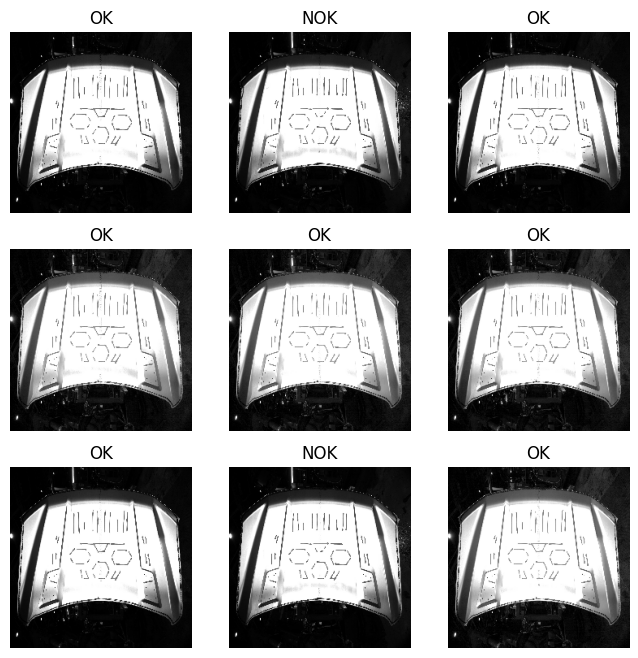

In [5]:
def show_sample_batch(dataset, class_names, num_images=9):
    plt.figure(figsize=(8, 8))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label = int(labels[i].numpy())
            plt.title(class_names[label])
            plt.axis("off")


train_ds, test_ds, class_names = load_datasets()

show_sample_batch(train_ds, class_names=class_names)



### Step 3 - Building the Model using Keras Archeticture

In [7]:
def build_ok_nok_model(img_size=IMG_SIZE):
    model = keras.Sequential([
        layers.Input(shape=(img_size, img_size, 3)), # input layer for RGB images
        layers.Rescaling(1.0 / 255), # rescale pixel values to [0, 1] - 255 is the maximum pixel value for an 8-bit image

        layers.Conv2D(32, (3, 3), activation="relu", padding="same"), # first convolutional layer using 32 filters
        layers.MaxPooling2D(), # first max pooling layer to reduce spatial dimensions so it helps in reducing computation time

        layers.Conv2D(64, (3, 3), activation="relu", padding="same"), # second convolutional layer using 64 filters
        layers.MaxPooling2D(), # second max pooling layer to reduce spatial dimensions so it helps in reducing computation time
        
        layers.Conv2D(128, (3, 3), activation="relu", padding="same"), # third convolutional layer using 128 filters
        layers.MaxPooling2D(), # third max pooling layer to reduce spatial dimensions so it helps in reducing computation time

        layers.Flatten(), # this is the actual flattening layer to convert 2D feature maps to 1D feature vectors so the model can process them
        layers.Dense(128, activation="relu"), # fully connected layer with 128 neurons
        layers.Dropout(0.5), # Optional dropout layer to reduce overfitting by randomly setting input units to 0 with a frequency of 0.5 at each step during training time
        layers.Dense(1, activation="sigmoid"), # output layer with 1 neuron and sigmoid activation for binary classification
    ])

    model.compile( # using the adam optimizer and binary crossentropy loss function for training methods 
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

model = build_ok_nok_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       7

### Step 4 - Training the Model

In [8]:

import tensorflow as tf

train_ds, test_ds, class_names = load_datasets()

# create validation from train (e.g., 20%)
train_size = int(0.8 * tf.data.experimental.cardinality(train_ds).numpy())
val_ds = train_ds.skip(train_size)
train_ds2 = train_ds.take(train_size)

model = build_ok_nok_model()

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
]

history = model.fit(
    train_ds2,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

MODEL_PATH = "models/ok_nok_model.h5"
model.save(MODEL_PATH)



Found 118 files belonging to 2 classes.
Found 106 files belonging to 2 classes.
Class names: ['NOK', 'OK']
Epoch 1/10
3/3 [==============================] - 11s 3s/step - loss: 2.1703 - accuracy: 0.5208 - val_loss: 1.3318 - val_accuracy: 0.3636
Epoch 2/10
3/3 [==============================] - 7s 2s/step - loss: 1.0498 - accuracy: 0.4792 - val_loss: 0.6742 - val_accuracy: 0.5455
Epoch 3/10
3/3 [==============================] - 7s 2s/step - loss: 0.6668 - accuracy: 0.6562 - val_loss: 0.6203 - val_accuracy: 0.6364
Epoch 4/10
3/3 [==============================] - 7s 2s/step - loss: 0.6292 - accuracy: 0.6042 - val_loss: 0.5615 - val_accuracy: 0.6364
Epoch 5/10
3/3 [==============================] - 7s 2s/step - loss: 0.5609 - accuracy: 0.7708 - val_loss: 0.5345 - val_accuracy: 0.7727
Epoch 6/10
3/3 [==============================] - 7s 2s/step - loss: 0.4690 - accuracy: 0.7917 - val_loss: 0.3603 - val_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 7s 2s/step - loss: 0

### Plotting the training results - optional

I added this section so I can use the training plots for the ppt slides

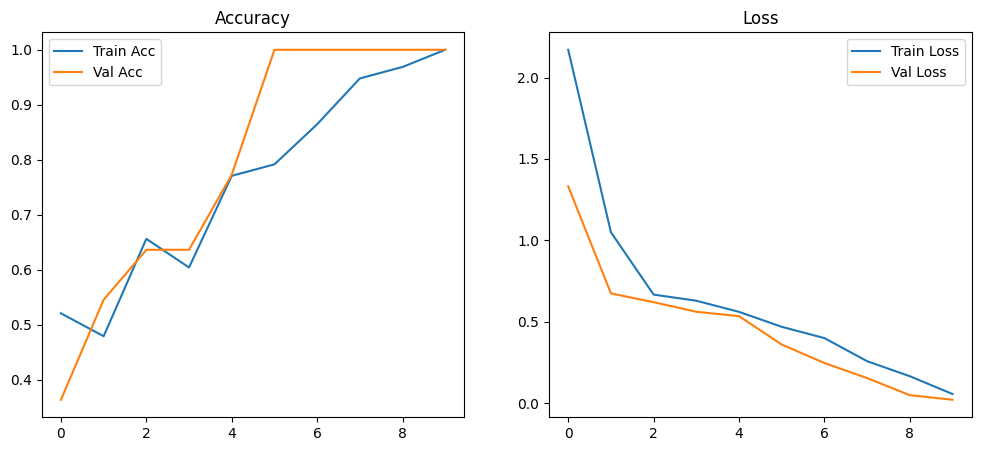

In [9]:
def plot_training_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Train Acc")
    plt.plot(epochs_range, val_acc, label="Val Acc")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Train Loss")
    plt.plot(epochs_range, val_loss, label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.show()


plot_training_history(history)


### Step 5 - Test the Model

Here I am testing the model and looking for the accuracy on how well its behaving based on the training methods used

In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, test_ds, class_names, threshold=0.5):
    y_true = []
    y_prob = []

    for x_batch, y_batch in test_ds:
        probs = model.predict(x_batch, verbose=0).reshape(-1)
        y_prob.extend(probs.tolist())
        y_true.extend(y_batch.numpy().reshape(-1).tolist())

    y_true = np.array(y_true).astype(int)
    y_pred = (np.array(y_prob) >= threshold).astype(int)

    # Ensure correct label order for confusion matrix & report
    # With label_mode="binary", Keras uses:
    # class_names[0] -> label 0, class_names[1] -> label 1
    labels = [0, 1]

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print("Class names:", class_names)
    print("Confusion matrix (rows=true, cols=pred):\n", cm)

    print("\nClassification report:\n")
    print(classification_report(
        y_true, y_pred,
        labels=labels,
        target_names=class_names,
        digits=2
    ))

    return cm



In [11]:
cm = evaluate_model(model, test_ds, class_names)


Class names: ['NOK', 'OK']
Confusion matrix (rows=true, cols=pred):
 [[44  6]
 [ 0 56]]

Classification report:

              precision    recall  f1-score   support

         NOK       1.00      0.88      0.94        50
          OK       0.90      1.00      0.95        56

    accuracy                           0.94       106
   macro avg       0.95      0.94      0.94       106
weighted avg       0.95      0.94      0.94       106



### Step 6 - Testing the Model on New Images

Here I am testing to see if the model can still predict new never before seen images and still be accurate and predict correctly

In [12]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_single_image(img_path, model, img_size=IMG_SIZE):
    # Load and resize, but DO NOT /255.0 here
    img = image.load_img(img_path, target_size=(img_size, img_size))
    x = image.img_to_array(img)          # values 0–255
    x = np.expand_dims(x, axis=0)        # (1, H, W, 3) for model

    # Model will normalize using the Rescaling layer
    prob_ok = model.predict(x)[0][0]
    label = "OK" if prob_ok >= 0.5 else "NOK"

    plt.imshow(image.load_img(img_path))
    plt.axis("off")
    plt.title(f"{label} (P(OK) = {prob_ok:.3f})")
    plt.show()

    return label, prob_ok




### Call Test

Testing OK Image:

1/1 [==============================] - 0s 60ms/step


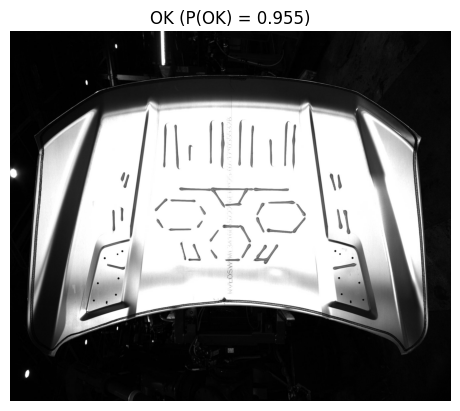

('OK', 0.9551384)

In [13]:
predict_single_image("data/test/OK/ok_test_052.jpg", model)


Testing NOK Image:

1/1 [==============================] - 0s 59ms/step


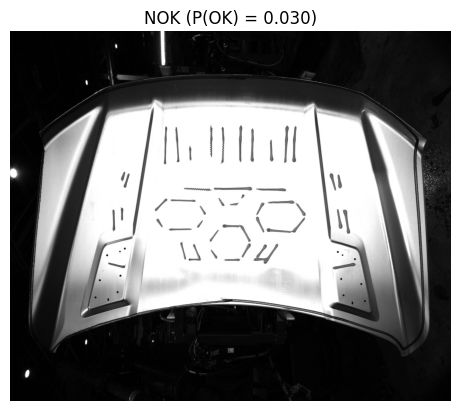

('NOK', 0.0297781)

In [14]:
predict_single_image("data/test/NOK/nok_test_041.jpg", model)


Testing All Images randomly selected:

In [15]:
import os
import random

def get_random_test_images(test_dir="data/test", num_images=10):
    image_paths = []

    # Collect OK images
    ok_dir = os.path.join(test_dir, "OK")
    for filename in os.listdir(ok_dir):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(ok_dir, filename))

    # Collect NOK images
    nok_dir = os.path.join(test_dir, "NOK")
    for filename in os.listdir(nok_dir):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(nok_dir, filename))

    # Shuffle randomly
    random.shuffle(image_paths)

    # Return only the amount you want
    return image_paths[:num_images]



Testing image: data/test\OK\ok_test_021.jpg
1/1 [==============================] - 0s 56ms/step


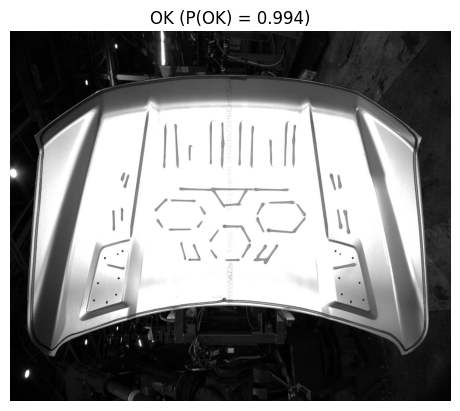


Testing image: data/test\OK\ok_test_022.jpg
1/1 [==============================] - 0s 59ms/step


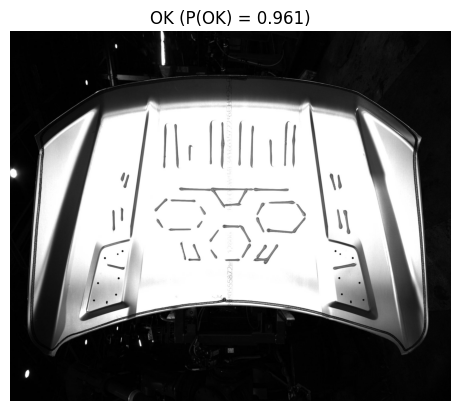


Testing image: data/test\OK\ok_test_034.jpg
1/1 [==============================] - 0s 64ms/step


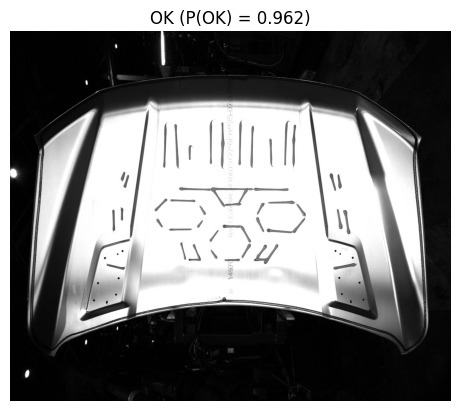


Testing image: data/test\NOK\nok_test_001.jpg
1/1 [==============================] - 0s 52ms/step


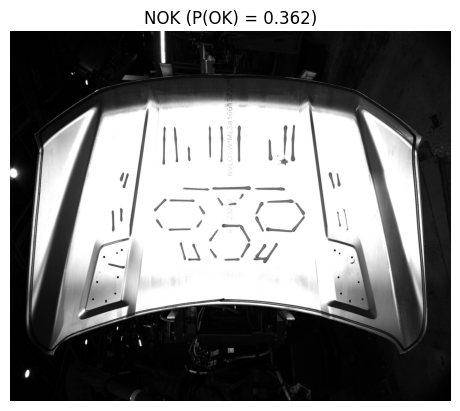


Testing image: data/test\NOK\nok_test_022.jpg
1/1 [==============================] - 0s 49ms/step


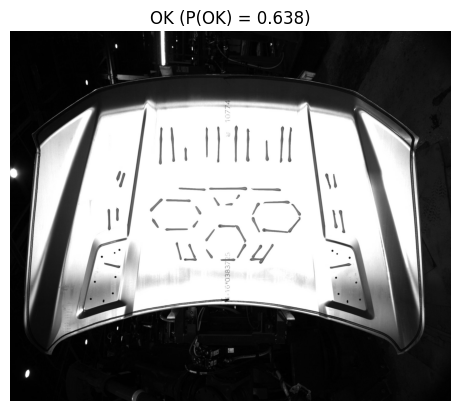


Testing image: data/test\OK\ok_test_005.jpg
1/1 [==============================] - 0s 58ms/step


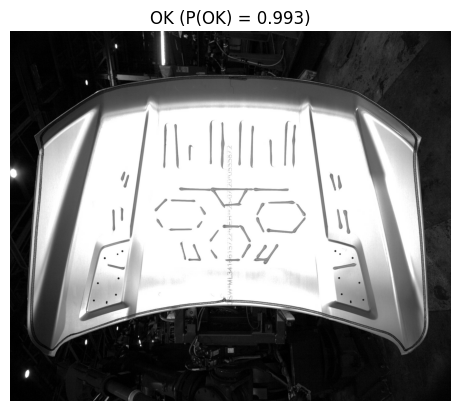


Testing image: data/test\NOK\nok_test_013.jpg
1/1 [==============================] - 0s 59ms/step


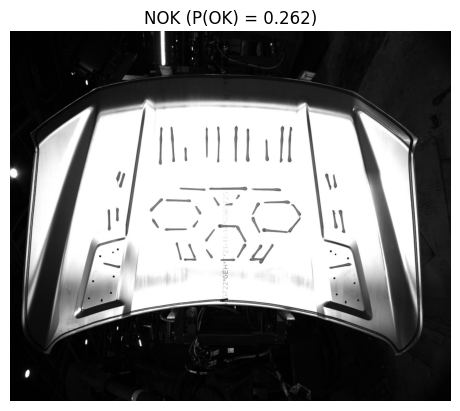


Testing image: data/test\OK\ok_test_010.jpg
1/1 [==============================] - 0s 54ms/step


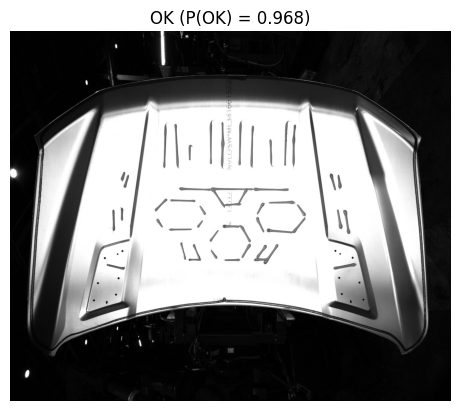


Testing image: data/test\NOK\nok_test_029.jpg
1/1 [==============================] - 0s 67ms/step


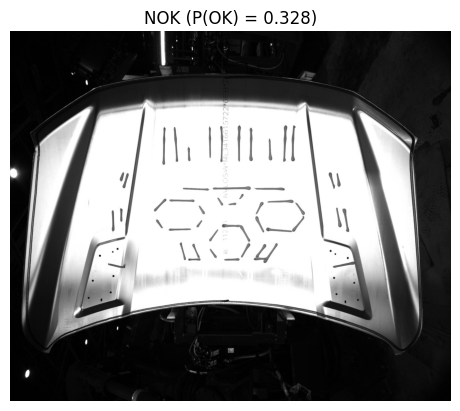


Testing image: data/test\OK\ok_test_048.jpg
1/1 [==============================] - 0s 50ms/step


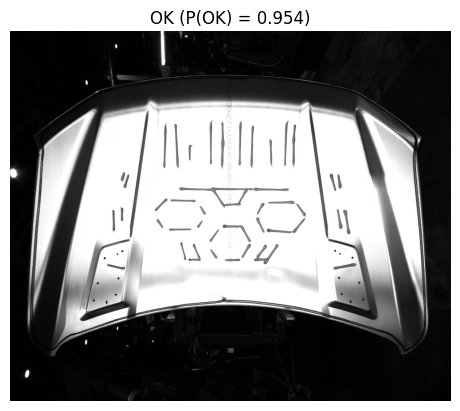

In [16]:
test_images = get_random_test_images(num_images=10)

for img_path in test_images:
    print(f"\nTesting image: {img_path}")
    predict_single_image(img_path, model)
